<img src="images/econ140R_logo.png" width="200" />

<h1>ECON 140R - Coding Bootcamp, Part 3</h1>

This material is closely and gratefully adapted from the work of the UC Berkeley EEP/IAS 118 team, including Jeremy Magruder, Sofia Villas-Boas, James Sears, and many other people working on these materials for EEP118. This is your work. We are in your debt!


## ggplot2

We started off using **R's** built-in plot function, which let us produce scatterplots and construct histograms of all sorts of variables. However, it doesn't look the best and has some ugly naming conventions. **ggplot2** will give us more control over our figure and allow us to get as in depth with it as we want. Check out the Wikipedia page on [ggplot2](https://en.wikipedia.org/wiki/Ggplot2) for details. The etymology is <i>Grammar of Graphics</i>.

<h5>DISCLAIMER:</h5> 
This notebook asks you to step through these functions in a piecemeal fashion. The early steps won't look like much!

**ggplot2** is part of the **tidyverse** package, so we'll need to load that in before we get started.

In [4]:
library(tidyverse)
library(haven)
sleepdata <- read_dta("sleep75.dta")
# The following seeds the random number generators (RNG) so that we'll get reproducible results

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# ggplot2 Basic Syntax

Let's start by getting familiar with the basic syntax of __ggplot2__. Its syntax is a little bit different than some of the functions we've used before, but ultimately it makes thing nice and easy as we make more and more professional-looking figures. It also plays nicely with pipes!

To start a plot, we start with the function

 `ggplot()`

This function initializes an empty plot and passes data to other plots that we'll add on top. We can also use this function to define our dataset or specify what our $x$ and $y$ variables are.

Try starting a new plot by running `ggplot()` &mdash; with no arguments &mdash; below:

<i>It's a blank canvas, just like the rest of your life, o butterfly!</i> OK, enough dad jokes.

We get a little bit more if we specify our data and our $x$ and $y$ variables. To specify the data, we add the argument `data = "dataname"` to the `ggplot()` function. 

To specify which variable is on the $x$ axis and which is on the $y$, we use the `aes(x= "xvar", y= "yvar")` argument. `aes()` is short for "aesthetics" and allows us to automatically pass these variables along as our $x$ and $y$ variables for the plots we add.

Let's say we're interested in using our `sleepdata` to see the relationship between age and hourly wage in our sample. Copy and paste this code into the field below and run it:

`ggplot(data = sleepdata, aes(x = age, y = hrwage))`

<b>NOTE:</b> In most regression applications, you will probably want to take the natural log of the hourly wage, or of income, or potentially of wealth. We skip that here for now, and you may want to skip it at first if you're concerned that there might be lots of zeros in the data. If there were lots of zeros, logging zeros drops those observations, and that may obscure the answer to the research question, depending on what it is. In most cases, economists would recommend that you log the wage first and then examine it.

That is a start! Now we have labels on both of our axes corresponding to the assigned variable, and a grid corresponding to possible values of those variables. This makes sense, as we told **R** with `aes()` what our $x$ variable and $y$ variable are, and then **R** automatically sets up tick marks based on our data.

We will add geometries (sets of points, histograms, lines, etc.) by adding what we call "layers" using a `+` after our `ggplot()` function. Let's take a look at a few of the options.


## Scatterplots

Now let's add some points! If we want to get a sense of how age and hourly wage vary in our data, we can do that by just plotting the points. We can add $(x,y)$ points in what is usually called a "scatterplot" using the function `geom_point()`. In spreadsheet programs, for example, Excel calls this an "X Y (Scatter)" chart.

Since we already declared our two variables, all we need to add `+ geom_point()` to our existing code: 

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point()`

This is a plot of <u>all our points</u>. This rendering could take a very long time if our dataset were enormous! Also, note that we were warned that there were rows that contained at least one missing value, and those got dropped.


### Labels

Often we'd like to change the labels from the variable names to a more descriptive label, and possibly add a title. We can, by adding the `labs()` function to our plot. Try pasting this in below and running:

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point() +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample",
        caption = "Note: prepared using Wooldridge's sleep75 data.",
        x = "Age (years)",
        y = "Hourly Wage ($)")`

Pretty nice, right? Suppose you wanted to leave the Jupyter world behind and write a document in Google Docs or Microsoft Word, or whatever you like. You can right-click or double-tap on the image above, copy it, and paste it into a document or other app to save it. On a Mac, I like to double-tap, "Save Image As," and then bring it down as a PNG to my desktop or folder where I'm working.

Let's take a look at what we added to `labs()`. 

* First, `title` gives us the main title at the top.
* `subtitle` gives us another line in a smaller font below the main title. 
* `caption` adds a note at the bottom of the plot
* `x` and `y` correspond to our x and y labels, respectively. 
* We can specify as many/few of these elements as we want, but just make sure to separate them by commas

### Changing Points

What if we want to change the color/shape/transparency of our points? We can do that by adding optimal arguments to `geom_point()`.

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(color = "blue", alpha = 0.4, size = 0.8) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample",
        x = "Age (years)",
        y = "Hourly Wage ($)")`

By adding `color="blue"` we changed the color to blue. There are [many named colors](http://sape.inf.usi.ch/sites/default/files/ggplot2-colour-names.png) that we could use instead. This gets really useful when we start splitting our data into groups.

The option `alpha = 0.4` changes the transparency of our points to 40%. `size = 0.8` reduces the size of the points to 80% of their original size.

### Splitting by Groups

What if we wanted to change the color of our points according to whether the individual is male or not? We can do that by adding an `aes()` to `geom_point` as follows. Try it out in the code box below.

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(aes(color = factor(male))) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample, by Gender",
        x = "Age (years)",
        y = "Hourly Wage ($)")`

By adding an aesthestic to our `geom_point` we can set the color to be determined by the value of `male`. By default, the zero value gets a red color, while a 1 value gets a light green, as shown in the legend that sits at far right by default. 

We specify this sorting variable with a call to `factor()` so that ggplot knows it is a discrete variable. What if we instead wanted to change color on a continuous scale? Let's toss in `age` instead of `male`. Age is measured in whole years, so it's not technically continuous but a list of integers, but you get the idea.

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(aes(color = age)) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample, by Age",
        x = "Age (years)",
        y = "Hourly Wage ($)")`

Here the color is now a function of our continuous variable `age`, taking increasingly lighter values for higher ages. Of course, `age` is also the $x$-variable, which makes this exercise a little redundant but still illuminating.

__ggplot2__ lets you specify the color scale or color levels if you want, as well as nitpick the labels in the legend. In reality we can change anything that appears in the plot; we just have to choose and edit the right option.

One thing to note is that we can make other options conditional on variables in our data frame too. What if we wanted the shape of our points to depend on union participation, the color to vary with gender, and the size of the points to depend on the total minutes worked per week? We can do all that, even if it might look messy:

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(aes(colour = factor(male), shape = factor(union), size = totwrk)) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample, too many things going on",
        x = "Age (years)",
        y = "Hourly Wage ($)")`

While the above example is very cluttered, it shows how we can take a simple scatterplot and use it to convey additional information in just one plot.

Use this power for good, never for evil. Spend a little extra time and create clear figures! A single "killer chart" is worth a lot.

## Lines

We can add lines to our figure in several different ways. First, if we wanted to connect all the points in our data with a line, we would use the `geom_line()` layer. For example, suppose we want to plot the <b>mean hourly wage</b> for each year of age in our data, we could code it this way with pipes:

`sleepdata %>% 
    group_by(age) %>% 
    drop_na(age, hrwage) %>%
    summarise(hrwage = mean(hrwage)) %>%
    ggplot(aes(x=age, y = hrwage)) +
    geom_line()`
    
Note that we include a call to `drop_na()` in order to drop the NA values beforehand so ggplot doesn't give us a warning. Try the code out below:

We can also add points (average wage for each age) just by adding another layer!

`sleepdata %>% 
    group_by(age) %>% 
    drop_na(age, hrwage) %>%
    summarise(hrwage = mean(hrwage))  %>%
    ggplot(aes(x=age, y = hrwage)) +
    geom_line()+
    geom_point(color = "gray40", alpha = 0.3)`

What if instead we wanted to add a vertical, horizontal, or sloped line in our plot? We could use the layers `vline()`, `hline()`, and `abline()` for that.

`vline()` is simple and really only needs the `xintercept` argument. Similarly, `hline` takes the `yintercept` argument. `abline` requires us to specify both a `slope` and an `intercept`.

Let's say we wanted to add lines to the previous set of points showing the average age (`geom_vline`), median hourly wage (`geom_hline`), and a dashed 45-degree line through the intersection of these two lines. Try out this code below:

`mean_age <- mean(sleepdata$age, na.rm = TRUE)
 med_wage <- median(sleepdata$hrwage, na.rm = TRUE)
 sleepdata %>% 
    group_by(age) %>% 
    drop_na(age, hrwage) %>%
    summarise(hrwage = mean(hrwage))  %>%
    ggplot(aes(x=age, y = hrwage)) +
    geom_point(colour = "gray40", alpha = 0.3) +
    geom_vline(xintercept = mean_age, colour = "orchid4") +
    geom_hline(yintercept = med_wage, colour = "steelblue") +
    geom_abline(intercept = -34.5, slope = 1, colour = "grey60", linetype = "dashed")`

Note that the 45-degree line doesn't actually look like a 45 degree line! That's not because we screwed it up; the slope is 1 unit, and that's correct. It looks weird because of the scaling of the axes, which __R__ sets according to the ranges of the $x$ and $y$ variables. Interested about axis settings? Stay tuned and read on.

## Histograms and Distributions


Sometimes we want to get information about one variable on its own. We can use __ggplot2__ to make histograms as well as predicted distributions!

We use the function `geom_histogram()` to produce histograms. To get a basic histogram of `age`, we can run

`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram()`

The pink warning box reveals that __ggplot2__ chooses a bin width by default, and we can change this by adding `binwidth`. Like before, we can also add labels or change color based on group membership.

If we want to change color, we now have two different options. `color` changes the outline color, while `fill` changes the interior color.

`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram(binwidth = 10, color = "seagreen4") +
    labs(title = "Age Histogram",
        x = "Age (years)",
        y = "Count")`
        
        
`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram(binwidth = 10, fill = "midnightblue") +
    labs(title = "Age Histogram",
        x = "Age (years)",
        y = "Count")`
        
        
`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram(binwidth = 10, color = "grey60", fill = "darkolivegreen1") +
    labs(title = "Age Histogram",
        x = "Age (years)",
        y = "Count")
`

### Stacking/Multiple Histograms

As with points or lines, we can create separate histograms on the same plot based on levels of another variable. 

`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram(aes(fill = factor(male)), position = "identity", 
                   alpha = 0.3, bins = 10) +
    labs(title = "Age Histogram",
         subtitle = "By Gender",
         x = "Age (years)",
         y = "Count")`

What's happening here? There are pink areas, which show bins of females that are larger than the bins of males; there are turquiose areas where the bins of males are larger than the bins of females; and then there are the darker teal areas, which show the overlap between groups.

Notice that we include the `position = "identity"` argument in `geom_histogram()` to tell __R__ that we want the position of each level of `male` to be its count. By default, __R__ wants to stack the two which results in incorrect frequencies for the two groups.

Other adjustments that we used are 
* `alpha = 0.3` sets the transparency so that both histograms are visible - this can be tweaked to your liking
* `bins = 10` replaces the `binwidth` argument and tells __R__ the number of bins that we want, automatically setting the width to produce them, rather than the width of each bin and adjusting the number of bins accordingly

We might also want to tweak the legend. The [**Legends**](#legends) section down below goes over this in more detail and for other plot types, but we can customize the legend with `scale_fill_manual()` and change the colors if we feel like it. Try out this code in the field below:

`ggplot(data = sleepdata, aes(x = age)) +
    geom_histogram(aes(fill = factor(male)), position = "identity", 
                   alpha = 0.3, bins = 10) +
    labs(title = "Age Histogram",
         subtitle = "By Gender",
         x = "Age (years)",
         y = "Count") +
    scale_fill_manual(name = "Gender", 
                      labels = c("Female", "Male"),
                      values = c("navy", "red"))`

What if we wanted to view a smoothed distribution of a variable rather than look at the potentially blocky histogram? We can do that with the `geom_density()` function, which uses a kernel density estimator, a standard approach. When I show distributions of test scores in the class, for example, I often show the actual data (histogram) and what a kernel density estimator shows, which usually looks more obviously like a bell curve. 

`ggplot(data = sleepdata, aes(x = age)) +
    geom_density(fill = "gray60", colour= "navy") +
    labs(title = "Age Density",
        x = "Age (years)",
        y = "Density")`

`ggplot(data = sleepdata, aes(x = age)) +
    geom_density(aes(colour = factor(male))) +
    labs(title = "Age Density",
        x = "Age (years)",
        y = "Density")`
        
Try this out below:

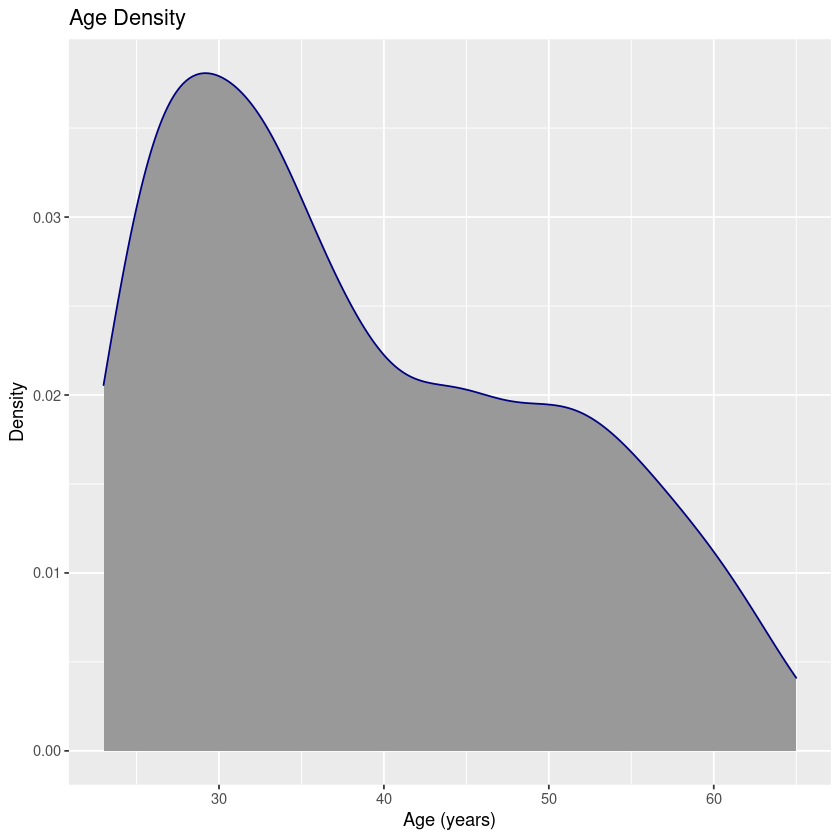

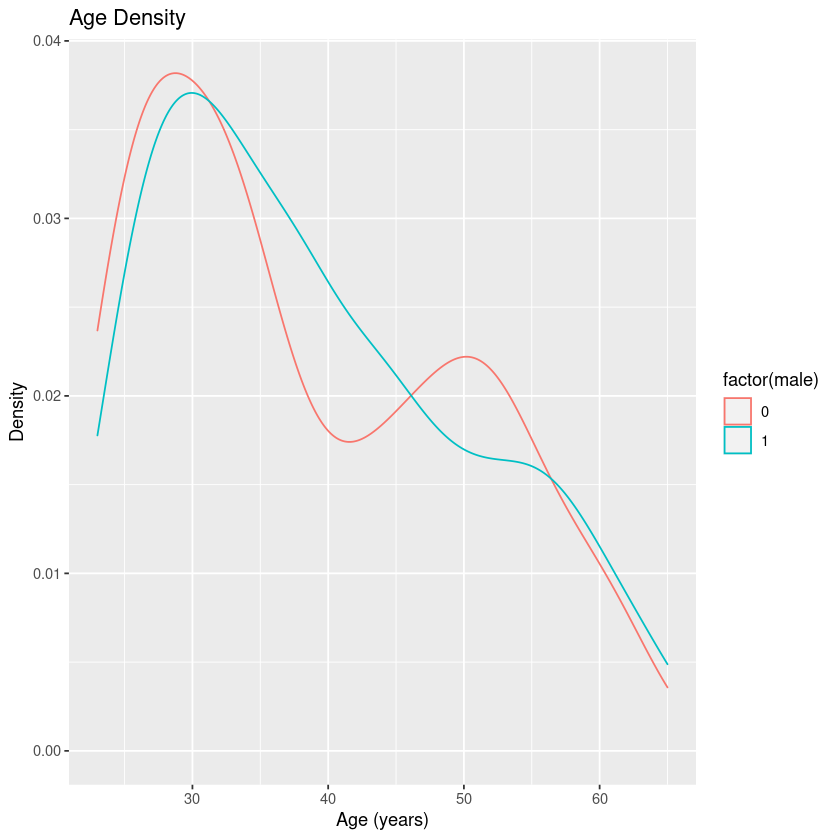

Cool, right? In this sample, there's some evidence of bimodality in the age distributions for females (`male == 0`).

## Plotting Regression Lines


Another cool thing that we can do with __ggplot2__ is produce a simple linear regression line directly in our plot. (It's also true that Microsoft Excel and Google Sheets can do this in their sleep. But __R__ can do so much more, and that's why we're using __R__ and not Excel.) 

We can use the `geom_smooth(method = "lm")` layer for that. Note that you don't have to run a regression before calling `gplot`. Including a `geom_smooth` layer will run the simple linear regression of $y$ on $x$ for you.

<b>BEWARE</b> the temptation to use this easy tool incorrectly. One of the reasons why Excel is insufficient for ECON 140 is that a simple bivariates regression of $y$ on a single $x$ is often insufficient for our purposes. Remember that this is all that `geom_smooth` in this basic form is actually doing.

`wagereg <- lm(hrwage ~ age, data = sleepdata)
summary(wagereg)`

`ggplot(data = sleepdata, aes(x=age, y = hrwage)) +
    geom_point()+
    geom_smooth(method = "lm")`

Notice that by default it gives us the 95% confidence interval too! We can change the confidence interval using the `level` argument and the color of the CI band with `fill` and the line with `color`:

`ggplot(data = sleepdata, aes(x=age, y = hrwage)) +
    geom_point()+
    geom_smooth(method = "lm", color = "steelblue", fill = "navy", level = 0.99)`

# Themes

Before we dive into more individualized adjustments, let's take a look at some of the default themes that come in ggplot2. You can access all of these themes just by including it with a `+` in your plot. A few examples include:

* `theme_gray()`
* `theme_bw()`
* `theme_linedraw()`
* `theme_light()`
* `theme_dark()`:
* `theme_minimal()`
* `theme_classic()`
* `theme_void()`


        
Try adding some of these themes to the following plot to see which you like.

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point() +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample",
        caption = "Note: prepared using Wooldridge's sleep75 data.",
        x = "Age (years)",
        y = "Hourly Wage ($)")`
        


## ggthemes

Loading the package [ggthemes](https://mran.microsoft.com/snapshot/2017-02-04/web/packages/ggthemes/vignettes/ggthemes.html)  gets us a bunch more theme options:

* theme_base: a theme resembling the default base graphics in R. See also theme_par.
* theme_calc: a theme based on LibreOffice Calc.
* theme_economist: a theme based on the plots in the The Economist magazine.
* theme_excel: a theme replicating the classic ugly gray charts in Excel
* theme_few: theme from Stephen Few’s “Practical Rules for Using Color in Charts”.
* theme_fivethirtyeight: a theme based on the plots at fivethirtyeight.com.
* theme_gdocs: a theme based on Google Docs.
* theme_hc: a theme based on Highcharts JS.
* theme_par: a theme that uses the current values of the base graphics parameters in par.
* theme_pander: a theme to use with the pander package.
* theme_solarized: a theme using the solarized color palette.
* theme_stata: themes based on Stata graph schemes.
* theme_tufte: a minimal ink theme based on Tufte’s The Visual Display of Quantitative Information.
* theme_wsj: a theme based on the plots in the The Wall Street Journal.

In [1]:
library(ggthemes)

Try taking one for a spin in the code box below:

## Custom Themes

In addition to using a pre-built theme, you can create custom themes and alter [just about every setting imaginable](https://ggplot2.tidyverse.org/reference/theme.html)! While you can change individual settings in every plot, you can also define a custom theme (i.e. in your preamble) and then call it by name later on.

For example, here's one very slightly adapted from one of Ed Rubin's custom themes (who also has a [tremendous set of R notes available on his website](http://edrub.in/teaching.html)):

`custom_theme <- theme(
  legend.position = "bottom", # place legend at the bottom
  panel.background = element_rect(fill = NA),  # change background color to white from grey
  axis.ticks = element_line(color = "grey95", size = 0.3), # make axis tick marks the same color as grid lines
  panel.grid.major = element_line(color = "grey95", size = 0.3), # change color of major grid lines (lines at displayed values)
  panel.grid.minor = element_line(color = "grey95", size = 0.3), #change color of minor grid lines (lines between displayed values)
  plot.caption = element_text(hjust = 0, face = "italic"), # left align bottom caption, make italic
  legend.key = element_blank()) # no legend key`
  
 
`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point() +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample",
        caption = "Note: prepared using Wooldridge's sleep75 data.",
        x = "Age (years)",
        y = "Hourly Wage ($)")+
        custom_theme`



# More Adjustments


## Changing Limits

To change limits of a plot without modifying the axes, add `xlim(min, max)` and `ylim(min, max)` where the arguments are numbers of the minimum and maximum values desired.

## Customizing Axes (Tick Marks, Limits, etc.)

To customize an axis, we'll use the `scale_x` and `scale_y` groups of functions. To customize a discrete axis, use `scale_x_discrete()` or `scale_y_discrete()`, and for a continuous variable use `scale_x_continuous()` or `scale_y_continuous()`. All four functions use the following main (but optional) arguments:

`(name, breaks, labels, limits)`

* **name** works the same as `labs` to add a label to the axis
* **breaks** controls where all the breaks are. Set to `NULL` to hide all ticks, or specify the breaks you want in a vector with `c()`.
* **labels** lets you replace the default tick mark labels with custom ones - again specify `NULL` or a custom vector
* **limits** lets you set the data range. This expects a character vector with two elements: `c(min, max)`


#### Number of Breaks
Suppose all you want to do is increase the number of breaks, and you don't care where those breaks occur. Then you could use the `n.breaks` argument in any of the above functions in place of `breaks`. 


<a id = "legends"></a>

## Legends

### Removing Some or All Legends

If you want to remove the entire legend, use

`theme(legend.position="none")`

If you want to instead remove the legend element for one aesthetic at a time, we can add it to the `guides()` option. For example, we can disable the fill colors from appearing in the legend with

`guide(fill = FALSE)`

Let's see an example: we can turn off the legend from our male/female scatterplot with:

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(aes(colour = factor(male))) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample, by Gender",
        x = "Age (years)",
        y = "Hourly Wage ($)") +
    guides(colour = FALSE)`

### Customizing Legends

We can customize the legends for the respective element using the `scale_ELM_manual()` family of functions, where **ELM** is one of

* **colour**
* **fill**
* **size**
* **shape**
* **linetype**
* **alpha**
* **discrete**

There are [many different options](https://ggplot2.tidyverse.org/reference/scale_manual.html) that we can customize for each scale.

For example, if we include both color and shape elements in our male/female scatterplot, we can change the shapes with `scale_shape_manual()`.

And we can combine this with turning off the legend for color too:

`ggplot(data = sleepdata, aes(x = age, y = hrwage)) +
    geom_point(aes(colour = factor(male), shape = factor(male))) +
    labs(title = "Relationship between Age and Hourly Wage",
        subtitle = "Nonmissing Sample, by Gender",
        x = "Age (years)",
        y = "Hourly Wage ($)")+
    scale_shape_manual(name = "Gender", labels = c("Female", "Male"), values = c(23, 24)) +
    guides(color = "none")`

# Summary

**ggplot2** is great for producing professional-looking figures and is capable of doing [a whole lot more](https://ggplot2.tidyverse.org/) than what's outlined here. You can use it to plot other types of geometric objects, make maps and analyze spatial data, create boxplots or heatmaps, and so much more! 

### Plug
Check out the (free) book by Garrett Grolemund and Hadley Wickham [R for Data Science](https://r4ds.had.co.nz/) for a more in-depth dive into ggplot and the rest of the tidyverse package.

<div style="text-align: right"> <span style="font-family:Papyrus; ">And they lived happily ever after. The End.</span></div>